In [1]:
import scanpy as sc

In [2]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

## 13.1 准备 monocle3

    - 花里胡哨，自带的去批次太差


In [43]:
## 13.1.1 读取注释后的数据
# 读入数据
ANNO_COL = "manual_celltype_annotation"
adata = sc.read("./anndata_manual_anno.h5ad")

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [44]:
adata = adata[adata.obs.group == "Disorder"]
adata = adata[adata.obs[ANNO_COL] == "Macrophages"]
adata = adata.raw.to_adata().copy()
adata

AnnData object with n_obs × n_vars = 26426 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_2', 'leiden_00_25', 'leiden_00_5', 'manual_celltype_anno

In [45]:
## 13.1.2 准备R环境
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri


%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [46]:
numpy2ri.activate()
pandas2ri.activate()  # type: ignore

In [47]:
## 13.2 准备变量
expression_matrix = adata.X.T
cell_metadata = adata.obs
gene_annotation = adata.var

In [48]:
expression_matrix

<17269x26426 sparse matrix of type '<class 'numpy.float64'>'
	with 42685129 stored elements in Compressed Sparse Row format>

In [49]:
adata

AnnData object with n_obs × n_vars = 26426 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_2', 'leiden_00_25', 'leiden_00_5', 'manual_celltype_anno

In [53]:
import scipy.sparse


def convert_csr_to_dense(matrix):
    """
    检查输入是否为 CSR 矩阵，并在需要时将其转换为密集矩阵。

    参数:
    matrix (scipy.sparse.csr_matrix or any): 要转换的矩阵。

    返回:
    numpy.ndarray or any: 转换后的密集矩阵或原始输入。
    """
    if isinstance(matrix, scipy.sparse.csr_matrix):
        # 将 CSR 矩阵转换为密集矩阵
        return matrix.toarray()
    else:
        # 如果不是 CSR 矩阵，返回原始输入
        return matrix.toarray()

In [51]:
expression_matrix = convert_csr_to_dense(expression_matrix)

In [37]:
# %pip install pandas==1.5.3

In [52]:
%%R -i expression_matrix -i cell_metadata -i gene_annotation
## 13.3 从R中构建cds对象
library(monocle3)
# 必须要一列名为gene_short_name
gene_annotation$gene_short_name = rownames(gene_annotation)
expression_matrix = as.matrix(expression_matrix)
cds <- new_cell_data_set(
    expression_matrix,
    cell_metadata = cell_metadata,
    gene_metadata = gene_annotation
                         )

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [54]:
%%R
# colnames(cds) = colData(cds)$C0
cds

class: cell_data_set 
dim: 17269 26426 
metadata(1): cds_version
assays(1): counts
rownames(17269): Vom2r6 Raet1l ... AABR07022739.1 AABR07024115.1
rowData names(11): mt ribo ... n_cells gene_short_name
colnames(26426): AAACGGGGTCGTCTTC-1_1 AAACGGGGTGTAATGA-1_1 ...
  TTTGGTTTCCATGAGT-1_33 TTTGTCATCAGAAATG-1_33
colData names(54): orig.ident nCount_RNA ... manual_celltype_annotation
  Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [40]:
# %%R
# ## 13.4预处理数据
# cds <- preprocess_cds(cds, num_dim = 50)
# cds <- align_cds(cds, alignment_group = "orig.ident")
# plot_pc_variance_explained(cds)

In [41]:
# %%R
# ## 13.5降维、可视化
# cds <- reduce_dimension(
#     cds,
#     reduction_method = c("Aligned"),
#     # 总之得先指定UMAP
#     cores=20,# 用多少核心
#     )
# plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "leiden")

In [55]:
int_embed = adata.obsm["X_umap"]

In [56]:
%%R -i int_embed

## 使用scanpy降维结果
cds@int_colData$reducedDims$UMAP <- int_embed#赋值

R[write to console]: No trajectory to plot. Has learn_graph() been called yet?



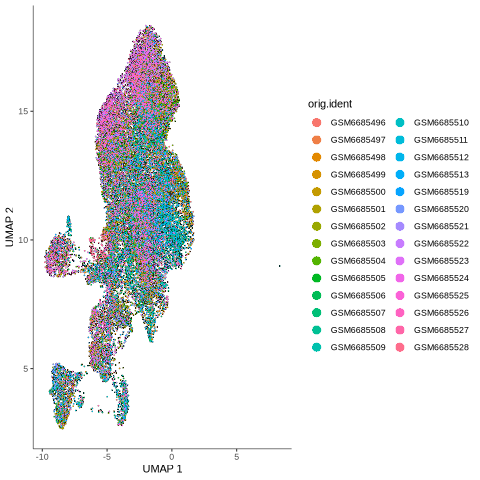

In [57]:
%%R
names(colData(cds))
## 13.4.1 检查批次效应
plot_cells(cds, color_cells_by="orig.ident", label_cell_groups=FALSE)

In [45]:
%%R
## 13.6 可视化单个基因如何沿着轨迹变化
# ciliated_genes <- c("TFF3", "CCL21", "PDPN")

# plot_cells(cds,
#            genes=ciliated_genes,
#            label_cell_groups=FALSE,
#            show_trajectory_graph=FALSE)

NULL


R[write to console]: set_nn_control: call stack: () => () => () => withVisible() => cluster_cells() => set_nn_control()

R[write to console]:   nn_control: 

R[write to console]:     method: annoy

R[write to console]:     metric: euclidean

R[write to console]:     n_trees: 50

R[write to console]:     search_k: 2000

R[write to console]:     cores: 1

R[write to console]:     grain_size: 1

R[write to console]: Running leiden clustering algorithm ...

R[write to console]: Run kNN based graph clustering starts:
  -Input data of 26426 rows and 2 columns
  -k is set to 20

R[write to console]:   Finding nearest neighbors...

R[write to console]: set_nn_control: call stack: () => () => () => withVisible() => cluster_cells() => leiden_clustering() => cluster_cells_make_graph() => make_nn_index() => set_nn_control()

R[write to console]:   nn_control: 

R[write to console]:     method: annoy

R[write to console]:     metric: euclidean

R[write to console]:     n_trees: 50

R[write to conso

   resolution_parameter quality modularity significance cluster_count selected
                  1e-04 1034925  0.8504691     628288.9             9        *


R[write to console]: 

R[write to console]:   Cell counts by cluster



   cluster cell_count cell_fraction
         1       5432         0.206
         2       4219         0.160
         3       4115         0.156
         4       3479         0.132
         5       2900         0.110
         6       2412         0.091
         7       1898         0.072
         8       1132         0.043
         9        839         0.032


R[write to console]: 

R[write to console]:   Maximal modularity is 0.850469084697724 for resolution parameter 1e-04

R[write to console]: 
  Run kNN based graph clustering DONE.
  -Number of clusters: 9

R[write to console]: No trajectory to plot. Has learn_graph() been called yet?



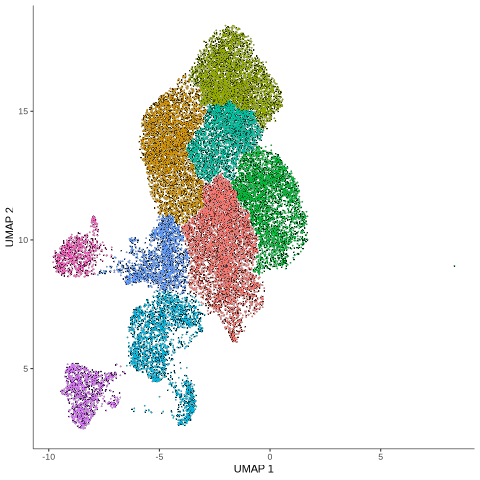

In [58]:
%%R
## 13.7 聚集细胞轨迹
cds <- cluster_cells(
    cds,
    verbose = TRUE
    ) 
plot_cells(cds, color_cells_by = "cluster", group_cells_by="partition")

  |======================================================================| 100%


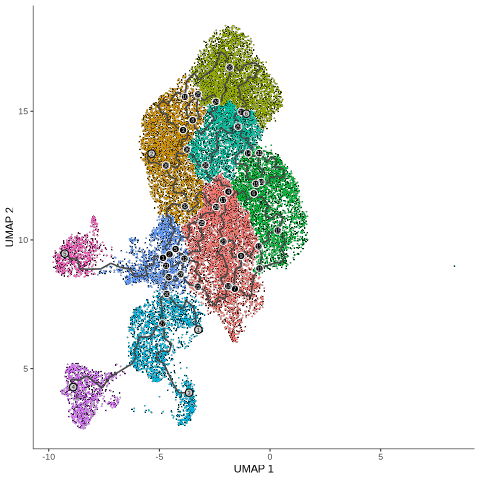

In [59]:
%%R
## 13.8 学习轨迹

cds <- learn_graph(
    cds, 
    # use_partition = F # 不使用聚类结果,如果大多是灰的话
)
plot_cells(
    cds,
    color_cells_by = "cluster",
    label_groups_by_cluster=T,
    label_leaves=T,
    label_branch_points=T
    )

computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` 
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99823326 0.9970892  0.9943301  0.99128866 0.9889053
     0.98220897 0.98082894 0.979032   0.97610575 0.9736841  0.97217244
     0.9690485  0.9662807  0.963553  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


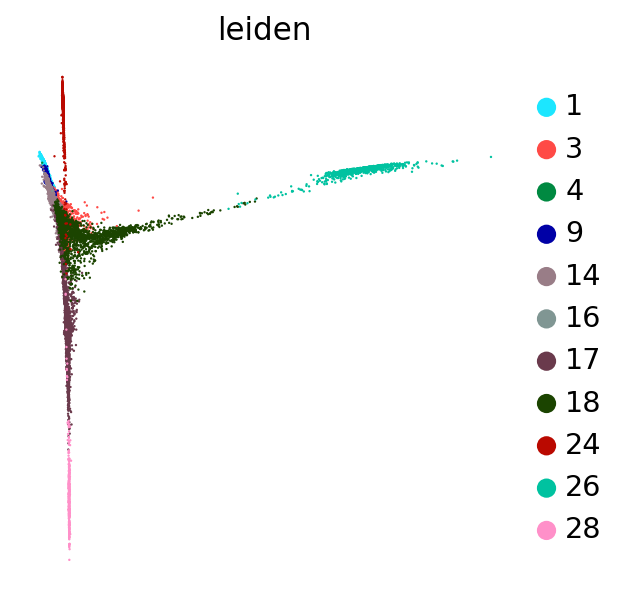

5613 GTGCGGTGTCCTGCTT-1_5


In [60]:
##  计算扩散伪时间（DPT）-我是为了找出根节点
sc.tl.diffmap(adata, random_state=123)
# Setting root cell as described above
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs
# 为了传给R,root_ixs是索引需要+1
root_ixs = root_ixs + 1
print(root_ixs, adata.obs_names[root_ixs])

In [61]:
%%R -i root_ixs
cds <- order_cells(
  cds,
  reduction_method = "UMAP",
#   root_pr_nodes = "Y_1",
  root_cells = colnames(cds)[root_ixs],
  verbose = True
)

cds$pseudotime <- cds@principal_graph_aux[["UMAP"]]$pseudotime[colnames(cds)]

In [50]:
%%R
## 13.9 伪时间排序

# # 最好是上游提供"embryo.time.bin"
# plot_cells(
#     cds,
#     color_cells_by = "embryo.time.bin", 
#     label_cell_groups=FALSE,
#     label_leaves=TRUE,
#     label_branch_points=TRUE,
#     graph_label_size=1.5
#     )

NULL


In [63]:
%%R
plot_cells(
    cds,
    color_cells_by = "pseudotime",
    label_cell_groups=FALSE,
    label_leaves=FALSE,
    label_branch_points=FALSE,
    graph_label_size=1.5
    )

ggsave("figures/08-monocle3-拟时序分化轨迹图.pdf")

Saving 6.67 x 6.67 in image


In [52]:
# %%R
# ## 一种自动找根节点的方法
# # a helper function to identify the root principal points:
# get_earliest_principal_node <- function(cds, time_bin="(4.34,8.68]"){
#   cell_ids <- which(colData(cds)[, "embryo.time.bin"] == time_bin)

#   closest_vertex <-cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
#   closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
#   root_pr_nodes <-
#   igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
#   (which.max(table(closest_vertex[cell_ids,]))))]

#   root_pr_nodes
# }
# cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds, time_bin="(39.1,43.5]"))

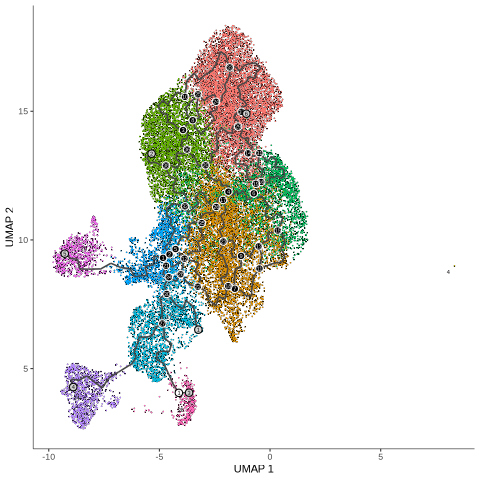

In [64]:
%%R
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "leiden")


- 图形自相关分析

In [65]:
%%R 
## 图形自相关分析

## 深入分析，选择单个分支比较快，这里选择整个图
subset_pr_test_res <- graph_test(cds, neighbor_graph="principal_graph", cores=20)
# 轨迹上附近位置的细胞对于被测试基因的表达水平是否相似（或不同
##morans_I（空间共表达）,其数值越靠近1代表这个基因在空间距离相近的细胞中表达值越相似，0则代表没有空间共表达效应
# subset_pr_test_res = subset(subset_pr_test_res, q_value < 0.05)
str(subset_pr_test_res)

  |=======================================================| 100%, Elapsed 02:11
'data.frame':	17269 obs. of  16 variables:
 $ status               : chr  "FAIL" "OK" "OK" "OK" ...
 $ p_value              : num  NA 2.20e-07 3.87e-32 5.12e-01 NaN ...
 $ morans_test_statistic: num  NA 5.0507 11.7424 -0.0297 NaN ...
 $ morans_I             : num  NA 9.16e-03 2.14e-02 -7.51e-05 -4.27e-05 ...
 $ mt                   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ ribo                 : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ hb                   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ n_cells_by_counts    : int  4 266 5283 6 3 35 5202 12403 4863 11092 ...
 $ mean_counts          : num  3.58e-05 2.53e-03 5.35e-02 5.37e-05 2.69e-05 ...
 $ log1p_mean_counts    : num  3.58e-05 2.52e-03 5.21e-02 5.37e-05 2.69e-05 ...
 $ pct_dropout_by_counts: num  100 99.8 95.3 100 100 ...
 $ total_counts         : num  4 282 5973 6 3 ...
 $ log1p_total_counts   : num  1.61 5.65 8.7 1.95 1.

In [ ]:
%%R
moransg <- row.names(subset(ciliated_cds_pr_test_res, q_value < 0.05))
gene_module_df <- find_gene_modules(cds[moransg,], resolution=c(10 ^ seq(-6, -1)))

cell_group_df <- tibble::tibble(cell=row.names(colData(cds)), 
                                cell_group=colData(cds)$cell.type)
agg_mat <- aggregate_gene_expression(cds, gene_module_df, cell_group_df)
row.names(agg_mat) <- stringr::str_c("Module ", row.names(agg_mat))
pheatmap::pheatmap(agg_mat,
                   scale="column", clustering_method="ward.D2")

In [96]:
%%R
library(dplyr)
library(ggplot2)
## 下面我们进行绘制单个基因在不同亚群之间的表达量变化
# 可以指定感兴趣的基因
# 这里就按照morans_I选择前十个基因

top10 <- subset_pr_test_res |> 
    subset(q_value < 0.05) |> 
    top_n(n=12, morans_I) |>
    pull(gene_short_name) |> 
    as.character()
## 来自基因优先级
top10 = c('Fez2', 'Fez1', 'Atp2a2', 'Atp6v1a', 'Gabarap', 'Kdr') 
# ['Fez2', 'Fez1', 'Atp2a2', 'Atp6v1a', 'Gabarap', 'Kdr']
top10 = top10[top10 %in% rownames(cds)]
top10

[1] "Fez2"    "Fez1"    "Atp2a2"  "Atp6v1a" "Gabarap" "Kdr"    


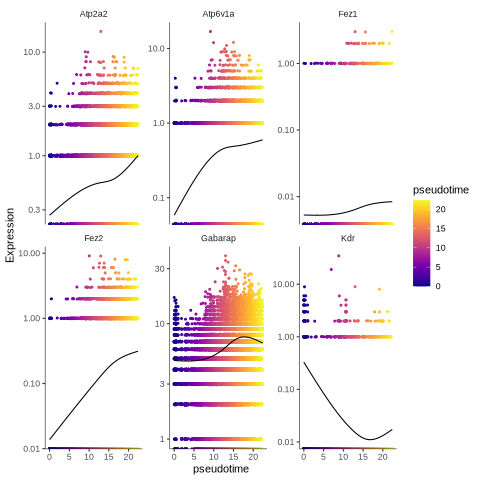

In [102]:
%%R
## 13.11 基因表达时间序列图
p1 = plot_genes_in_pseudotime(cds[top10,], color_cells_by="pseudotime", 
                             min_expr=0, ncol = 3)
ggsave("figures/08-monocle3-基因表达时间序列图.pdf",p1, width = 14, height = 8)
p1

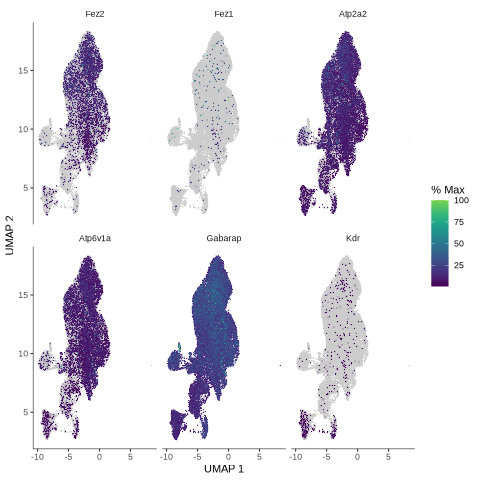

In [99]:
%%R
#基因特征图
p2 = plot_cells(cds, genes=top10, show_trajectory_graph=FALSE,label_cell_groups=FALSE,  label_leaves=FALSE)
ggsave("figures/08-monocle3-基因表达聚类图.pdf",p2, width = 17, height = 10)
p2

- 回归分析


In [68]:
%%R 

ciliated_genes <- c('Fez2', 'Fez1', 'Atp2a2', 'Atp6v1a', 'Gabarap', 'Kdr') 
cds_subset <- cds[rowData(cds)$gene_short_name %in% ciliated_genes,]
cds_subset

class: cell_data_set 
dim: 6 26426 
metadata(2): cds_version citations
assays(1): counts
rownames(6): Fez2 Fez1 ... Atp6v1a Atp2a2
rowData names(11): mt ribo ... n_cells gene_short_name
colnames(26426): AAACGGGGTCGTCTTC-1_1 AAACGGGGTGTAATGA-1_1 ...
  TTTGGTTTCCATGAGT-1_33 TTTGTCATCAGAAATG-1_33
colData names(55): orig.ident nCount_RNA ... Size_Factor pseudotime
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [85]:
%%R 
fit = fit_models(cds_subset, model_formula_str="~pseudotime+batch")
fit_coefs <- coefficient_table(fit)
emb_time_terms <- fit_coefs %>% 
    filter(term == "pseudotime") %>% 
    filter(term != "(Intercept)")
emb_time_terms %>% filter (q_value < 0.05) %>%
         select(gene_short_name, term, q_value, estimate)

# A tibble: 5 × 4
  gene_short_name term         q_value estimate
  <chr>           <chr>          <dbl>    <dbl>
1 Fez2            pseudotime 2.94e-235   0.121 
2 Kdr             pseudotime 1.13e- 75  -0.185 
3 Gabarap         pseudotime 0           0.0320
4 Atp6v1a         pseudotime 7.48e-147   0.0562
5 Atp2a2          pseudotime 3.31e-126   0.0448


In [95]:
%%R
evaluate_fits(fit)
# plot_genes_violin(cds_subset, group_cells_by = "pseudotime", ncol = 2) +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

# plot_genes_hybrid(cds_subset, group_cells_by = "pseudotime", ncol = 2) +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

# A tibble: 6 × 21
  mt    ribo  hb    n_cells_by_counts mean_counts log1p_mean_counts
  <lgl> <lgl> <lgl>             <int>       <dbl>             <dbl>
1 FALSE FALSE FALSE             15103       0.163             0.151
2 FALSE FALSE FALSE             11268       0.128             0.121
3 FALSE FALSE FALSE              5770       0.114             0.108
4 FALSE FALSE FALSE             97049       5.33              1.85 
5 FALSE FALSE FALSE             20873       0.243             0.218
6 FALSE FALSE FALSE             42282       0.597             0.468
# ℹ 15 more variables: pct_dropout_by_counts <dbl>, total_counts <dbl>,
#   log1p_total_counts <dbl>, n_cells <int>, gene_short_name <chr>,
#   num_cells_expressed <int>, gene_id <chr>, status <chr>,
#   null_deviance <dbl>, df_null <int>, logLik <lgl>, AIC <dbl>, BIC <dbl>,
#   deviance <dbl>, df_residual <int>


- 评估基因表达模型
表达式_系列	分配	准确性	速度	笔记

quasipoisson	拟泊松	++  	++	默认为fit_models()。推荐给大多数用户。

negbinomial	负二项式	+++	  +	推荐给拥有较小数据集（少于 1,000 个单元格）的用户。

poisson	泊松	-	  +++	不推荐。仅用于调试和测试。

binomial	二项式	++	  ++	推荐用于单细胞 ATAC-seq

# A tibble: 6 × 21
  mt    ribo  hb    n_cells_by_counts mean_counts log1p_mean_counts
  <lgl> <lgl> <lgl>             <int>       <dbl>             <dbl>
1 FALSE FALSE FALSE             15103       0.163             0.151
2 FALSE FALSE FALSE             11268       0.128             0.121
3 FALSE FALSE FALSE              5770       0.114             0.108
4 FALSE FALSE FALSE             97049       5.33              1.85 
5 FALSE FALSE FALSE             20873       0.243             0.218
6 FALSE FALSE FALSE             42282       0.597             0.468
# ℹ 15 more variables: pct_dropout_by_counts <dbl>, total_counts <dbl>,
#   log1p_total_counts <dbl>, n_cells <int>, gene_short_name <chr>,
#   num_cells_expressed <int>, gene_id <chr>, status <chr>,
#   null_deviance <dbl>, df_null <int>, logLik <lgl>, AIC <dbl>, BIC <dbl>,
#   deviance <dbl>, df_residual <int>


In [37]:
%%R -o pseudotime

pseudotime <- colData(cds)$pseudotime

In [38]:
adata.obs["pseudotime"] = pseudotime  # type: ignore
adata.write("anndata_monocle3.h5ad")  # type: ignore

In [73]:
%%R
saveRDS(cds, "cds.rds")